In [4]:
import os
import sys
# path to settings
sys.path.insert(0, os.path.split(os.getcwd())[0])
# path to src/models
sys.path.insert(1, os.path.join(os.path.split(os.getcwd())[0], 'src/models/'))

from settings import MODEL_DIR, FIGURES_DIR, TEST_DIR, FILTER_SPECTROGRAM_DIR
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from model import get_model
import matplotlib.pyplot as plt
import keras
import itertools
import re
import numpy as np


def natural_sort(l):
    '''
    needed in order to sort numbers and strings
    '''
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

# took from scikit-learn.org example


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Using TensorFlow backend.


In [5]:
# dimensions of our images
img_height, img_width = 480, 20
input_shape = (img_height, img_width, 3)
num_classes = 7

class_labels = [[
        'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'blank'
    ], [
        'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'blank'
    ]
]

data_models = os.listdir(TEST_DIR)

Found 734 images belonging to 7 classes.
Found 771 images belonging to 7 classes.


Found 369 images belonging to 7 classes.
Confusion matrix, without normalization
[[53  1  0  0  0  0  0]
 [ 0 47  0  0  0  0  0]
 [ 0  0 57  0  0  0  0]
 [ 0  0  0 44  0  0  0]
 [ 0  0  0  0 72  1  0]
 [ 0  0  0  0  0 56  0]
 [ 0  0  0  0  0  0 38]]


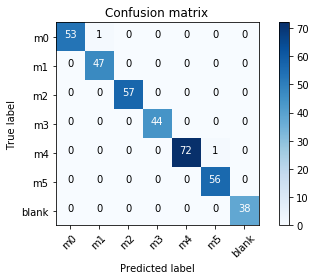

Found 419 images belonging to 7 classes.
Confusion matrix, without normalization
[[38  0  0  0  0  0  0]
 [ 0 60  0  0  1  1  0]
 [ 0  0 47  0  1  5  0]
 [ 0  0  0 67  0  2  0]
 [ 0  1  0  0 71 18  1]
 [ 0  0  0  0  5 57  2]
 [ 0  0  1  0  0  2 39]]


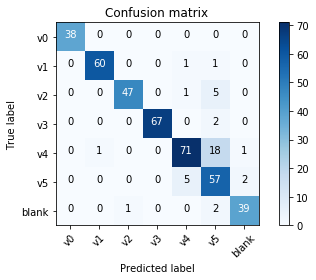

In [12]:
for l_idx, data_model in enumerate(data_models):

    # model must be the same as trained
    model = get_model(input_shape, num_classes)

    # load the model we saved
    model.load_weights(MODEL_DIR + data_model + '/' + 'model_25.h5')
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
    )

    # use test set
    test_datagen = image.ImageDataGenerator(rescale=1. / 255)

    batch_size = 50
    test_batches = test_datagen.flow_from_directory(
        TEST_DIR + data_model + '/',
        target_size=(img_height, img_width),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical'
    )

    true_classes = []
    predicted_classes = []

    folders = os.listdir(TEST_DIR + data_model + '/')
    folders = natural_sort(folders)

    for i, folder in enumerate(folders):

        class_folder = TEST_DIR + data_model + '/' + folder
        class_image_data = []

        for data in os.listdir(class_folder):

            image_path = class_folder + '/' + data

            img = image.load_img(
                image_path, target_size=(img_height, img_width))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            class_image_data.append(x)

        # add true class index as many times as there are test data for that
        # class
        true_classes.extend([i] * len(class_image_data))

        # stack arrays vertically
        array_row = np.vstack(class_image_data)

        # predicted class
        predicted_class = model.predict_classes(array_row, batch_size=20)
        predicted_classes.extend(predicted_class)

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure("Confusion matrix")
    plot_confusion_matrix(cm, class_labels[l_idx])
    plt.savefig(FIGURES_DIR + data_model + '/' + 'confusion_matrix3.jpg')
    plt.show()